In [349]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from iminuit import Minuit
from iminuit.cost import LeastSquares
from scipy.signal import find_peaks
from iminuit.util import propagate




In [350]:
#File paths
m1_neg_file='/Users/christopherwitt/F-Praktikum/NV Centers/Experiment 2/Data/m1-neg_1_05_2/20251029-1146-01_wainteach_gui.dat'
m1_pos_file='/Users/christopherwitt/F-Praktikum/NV Centers/Experiment 2/Data/m1-pos_1_05_2/20251029-1141-34_wainteach_gui.dat'

m2_neg_file='/Users/christopherwitt/F-Praktikum/NV Centers/Experiment 2/Data/m2-neg_+2deg/20251029-1202-01_wainteach_gui.dat'
m2_pos_file='/Users/christopherwitt/F-Praktikum/NV Centers/Experiment 2/Data/m2-pos_+2deg/20251029-1206-52_wainteach_gui.dat'

m3_neg_file='/Users/christopherwitt/F-Praktikum/NV Centers/Experiment 2/Data/m3-neg_-2deg/20251029-1209-37_wainteach_gui.dat'
m3_pos_file='/Users/christopherwitt/F-Praktikum/NV Centers/Experiment 2/Data/m3-pos_-2deg/20251029-1213-17_wainteach_gui.dat'

In [351]:
def load_data(filename):
    df = pd.read_csv(
        filename,
        comment='#',
        delim_whitespace=True,
        encoding='latin1'  # oder alternativ: encoding='ISO-8859-1'
    )
    df.columns = ['Frequenz', 'Voltage']
    Voltage=np.array(df['Voltage'])
    Frequenz=np.array(df['Frequenz'])
    data=[Frequenz,Voltage]
    return data


In [352]:
m1_neg_data = np.array(load_data(m1_neg_file))
m1_pos_data = np.array(load_data(m1_pos_file))

m2_neg_data = np.array(load_data(m2_neg_file))
m2_pos_data = np.array(load_data(m2_pos_file))

m3_neg_data = np.array(load_data(m3_neg_file))
m3_pos_data = np.array(load_data(m3_pos_file))

/var/folders/bg/b44vpd1j713_48yg885ptdvw0000gn/T/ipykernel_6813/3927440244.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
/var/folders/bg/b44vpd1j713_48yg885ptdvw0000gn/T/ipykernel_6813/3927440244.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
/var/folders/bg/b44vpd1j713_48yg885ptdvw0000gn/T/ipykernel_6813/3927440244.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
/var/folders/bg/b44vpd1j713_48yg885ptdvw0000gn/T/ipykernel_6813/3927440244.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
/var/folders/bg/b44vpd1j713_

In [353]:


def lorentz(x, x0, gamma, A):
    return A * (0.5 * gamma)**2 / ((x - x0)**2 + (0.5 * gamma)**2)

def triple_lorentz(x, x01, g1, A1, x02, g2, A2, x03, g3, A3, offset):
    return (
        lorentz(x, x01, g1, A1) +
        lorentz(x, x02, g2, A2) +
        lorentz(x, x03, g3, A3) +
        offset
    )

def fit_triple_lorentz_auto(x, y, yerr=None):

    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    if yerr is None:
        yerr = np.full_like(y,0.000533)

    # --- 1. Drei tiefste Minima suchen ---
    peaks, _ = find_peaks(-y, distance=len(x)/6)
    peaks = peaks[np.argsort(y[peaks])[:3]]  # drei tiefste
    peaks = np.sort(peaks)

    # --- 2. Startparameter schätzen ---
    if len(peaks) < 3:
        print("⚠️ Weniger als 3 Minima gefunden – Zufallsstartwerte verwendet.")
        peaks = np.linspace(x[0], x[-1], 3, dtype=int)

    x0s = x[peaks]
    g_est = (x[-1] - x[0]) / 100
    A_est = np.min(y) - np.mean(y)
    offset = np.mean(y)

    start = dict(
        x01=x0s[0], g1=g_est, A1=A_est,
        x02=x0s[1], g2=g_est, A2=A_est,
        x03=x0s[2], g3=g_est, A3=A_est,
        offset=offset
    )

    # --- 3. Least Squares Fit ---
    least_squares = LeastSquares(x, y, yerr, triple_lorentz)
    m = Minuit(least_squares, **start)
    m.errordef = Minuit.LEAST_SQUARES
    m.migrad()
    m.hesse()
    

    return m


def calculate_minimum(x, fit_result):
    x_fit = np.linspace(np.min(x), np.max(x), 1000)
    y_fit = triple_lorentz(x_fit, *fit_result.values)
    peaks, _ = find_peaks(-y_fit, distance=len(x_fit)/6)
    peak_positions = x_fit[peaks]
    peak_values = y_fit[peaks]

    plt.vlines(peak_positions[1], ymin=np.min(y_fit), ymax=np.max(y_fit)*1.002, colors='green', linestyles='dashed')
    plt.text(peak_positions[1]-0.5*10**7, np.max(y_fit)*1.002, f' {peak_positions[1]/1000000000:.2f} GHz', color='green')
    return peak_positions[1]


def plot_lorenz_fit(x, y, yerr=None, start_params=None,name=None):
    m=fit_triple_lorentz_auto(x, y, yerr)
    x_fit = np.linspace(np.min(x), np.max(x), 1000)
    y_fit = triple_lorentz(x_fit, *m.values)
    frequenz=calculate_minimum(x,m)
    plt.plot(x_fit, y_fit, label=name, color='red')
    plt.xlabel('Frequenz (GHz)')
    plt.ylabel('Voltage (V)')
    return m,frequenz

In [354]:


def find_minima_intervals(x, y, n_minima=8, half_window_points=25, plot=True):


    # In numpy-Arrays konvertieren
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    # Minima finden → Peaks im invertierten Signal
    peaks, _ = find_peaks(-y, distance=len(x) / (n_minima * 2))

    # Nur die n_minima tiefsten behalten
    if len(peaks) > n_minima:
        sorted_idx = np.argsort(y[peaks])  # tiefste zuerst
        peaks = peaks[sorted_idx[:n_minima]]

    # Nach Frequenz sortieren
    peaks = np.sort(peaks)

    # Indexintervalle bestimmen
    intervals = []
    for p in peaks:
        i_start = max(0, p - half_window_points)
        i_end = min(len(x) - 1, p + half_window_points)
        intervals.append((i_start, i_end))

    # Plot optional
    if plot:
        plt.figure(figsize=(8, 4))
        plt.plot(x, y, 'b-', label="Signal")
        plt.plot(x[peaks], y[peaks], 'ro', label="Gefundene Minima")
        for (i1, i2) in intervals:
            plt.axvspan(x[i1], x[i2], color='orange', alpha=0.2)
        plt.xlabel("Frequenz (Hz)")
        plt.ylabel("Spannung (V)")
        plt.legend()
        plt.title("Automatisch erkannte Minima & Indexintervalle")
        #plt.show()

    return intervals

    



/Users/christopherwitt/Library/Python/3.9/lib/python/site-packages/iminuit/minuit.py:139: ErrordefAlreadySetWarning: cost function has an errordef attribute equal to 1.0, you should not override this with Minuit.errordef
  warnings.warn(msg, ErrordefAlreadySetWarning)


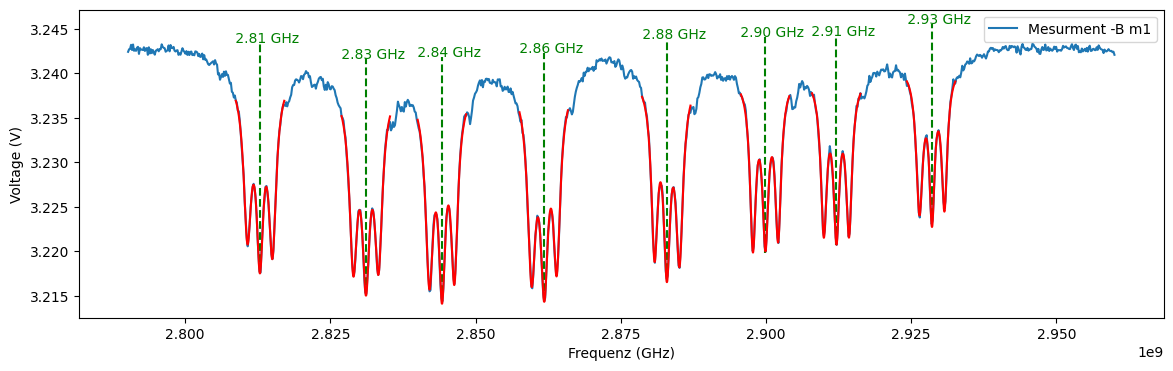

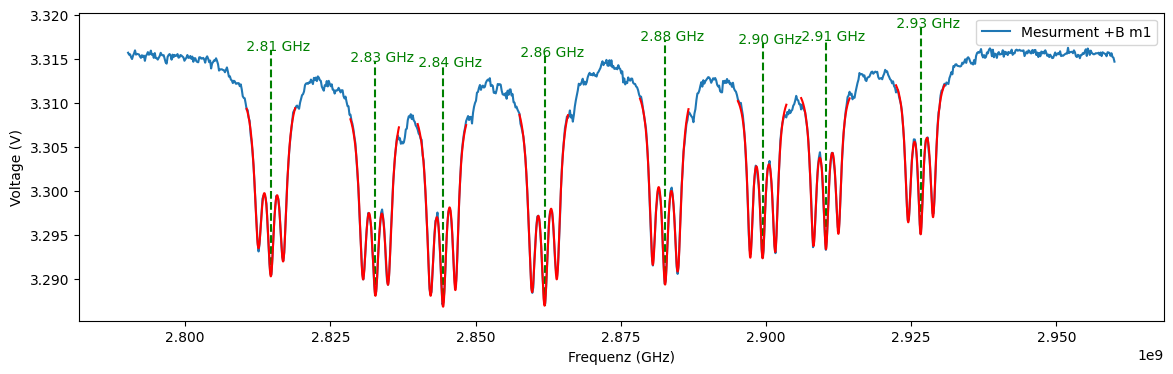

Delta fi +B 1: 111.89 MHz
Delta fi -B 1: 115.71 MHz
Delta fi +B 2: 93.88 MHz
Delta fi -B 2: 97.45 MHz
Delta fi +B 3: 82.23 MHz
Delta fi -B 3: 84.36 MHz
Delta fi +B 4: 64.75 MHz
Delta fi -B 4: 66.76 MHz
B_earth 1: 2030.45 uT
B_earth 2: 1706.84 uT
B_earth 3: 1486.13 uT
B_earth 4: 1173.17 uT
B_earth_x: 4.62 uT
B_earth_y: 2769.80 uT
B_earth_z: 2769.80 uT
B_earth_magnitude: 3917.10 uT


([┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 6.507 (χ²/ndof = 0.2)      │              Nfcn = 757              │
│ EDM = 2.46e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──

In [355]:
def alalyze_data(data, n_minima=8,name=''):
    x = data[0]
    y = data[1]
    plt.plot(x, y, label=name)
    m_list=[]
    res_freqs_list=[]
    intervalls=find_minima_intervals(x, y, n_minima=8, plot=False)
    for i in range(8):
        m,res_freq=plot_lorenz_fit(x[intervalls[i][0]:intervalls[i][1]], y[intervalls[i][0]:intervalls[i][1]],name=None)
        m_list.append(m)
        res_freqs_list.append(res_freq)
        plt.legend()
    plt.grid()
    #plt.show()
    return m_list,res_freqs_list

def calculate_B_earth(res_freqs_neg,res_freqs_pos):
    delta_fi_pos_list=[]
    delta_fi_neg_list=[]
    for i in range(4):
        delta_fi_pos=-res_freqs_pos[i]+res_freqs_pos[7]
        delta_fi_neg=-res_freqs_neg[i]+res_freqs_neg[7]
        delta_fi_pos_list.append(delta_fi_pos)
        delta_fi_neg_list.append(delta_fi_neg)
    
    for i in range(4):
        print(f"Delta fi +B {i+1}: {delta_fi_pos_list[i]/1e6:.2f} MHz")
        print(f"Delta fi -B {i+1}: {delta_fi_neg_list[i]/1e6:.2f} MHz")

    gamma=28.024e9  # Hz/T
    B_earth_i_list=[]
    for i in range(4):
        B_earth_i=(delta_fi_pos_list[i]+delta_fi_neg_list[i])/(4*gamma)
        print(f"B_earth {i+1}: {B_earth_i*1e6:.2f} uT")
        B_earth_i_list.append(B_earth_i)


    B_earth_x=(np.sqrt(3)/4)*(B_earth_i_list[0]-B_earth_i_list[1]-B_earth_i_list[2]+B_earth_i_list[3])
    B_earth_y=(np.sqrt(3)/4)*(B_earth_i_list[0]-B_earth_i_list[1]+B_earth_i_list[2]-B_earth_i_list[3])
    B_earth_y=(np.sqrt(3)/4)*(B_earth_i_list[0]+B_earth_i_list[1]+B_earth_i_list[2]+B_earth_i_list[3])

    B_earth_magnitude=np.sqrt(B_earth_x**2+B_earth_y**2+B_earth_y**2)

    print(f"B_earth_x: {B_earth_x*1e6:.2f} uT")
    print(f"B_earth_y: {B_earth_y*1e6:.2f} uT")
    print(f"B_earth_z: {B_earth_y*1e6:.2f} uT")
    print(f"B_earth_magnitude: {B_earth_magnitude*1e6:.2f} uT")

    return delta_fi_pos_list,delta_fi_neg_list,B_earth_i_list


def full_analysis(neg_data,pos_data,name=''):
    x_size=14
    y_size=4

    plt.figure(figsize=(x_size, y_size))
    m_neg,res_freq_neg=alalyze_data(neg_data,name=f'Mesurment -B {name}')
    plt.grid()
    plt.show()
    plt.figure(figsize=(x_size, y_size))
    m_pos,res_freq_pos=alalyze_data(pos_data,name=f'Mesurment +B {name}')
    plt.grid()
    plt.show()
    delta_fi_pos_list,delta_fi_neg_list,B_earth_i_list=calculate_B_earth(res_freq_neg,res_freq_pos)
    return m_neg,res_freq_neg,m_pos,res_freq_pos,delta_fi_pos_list,delta_fi_neg_list,B_earth_i_list
        

full_analysis(m1_neg_data,m1_pos_data,name='m1')



In [356]:


import pandas as pd
import numpy as np

def get_lartech(m_list):
    """
    Erstellt eine LaTeX-Tabelle aus einer Liste von Minuit-Objekten (m_list),
    mit Werten ± Fehlern, gruppiert nach 10^{3n} pro Parameter.
    """
    params = m_list[0].parameters

    # Bestimme Exponenten (in 3er-Schritten) je Parameter basierend auf erstem Fit
    exp_by_param = {}
    for p in params:
        val = m_list[0].values[p]
        exp = 0 if val == 0 else int(np.floor(np.log10(abs(val)) / 3) * 3)
        exp_by_param[p] = exp

    # Hilfsfunktion: formatierte Zahl (ohne 10^n)
    def fmt(val, err, exp):
        scale = 10 ** (-exp)
        return f"${val*scale:.3f} \\pm {err*scale:.3f}$"

    # DataFrame-Daten vorbereiten
    data = {"Parameter": [f"{p} ($\\times 10^{{{exp_by_param[p]}}}$)" if exp_by_param[p] != 0 else p for p in params]}

    for i, m in enumerate(m_list, start=1):
        data[f"{i}. Fit"] = [
            fmt(m.values[p], m.errors[p], exp_by_param[p]) for p in params
        ]

    df = pd.DataFrame(data)

    # Ausgabe als LaTeX-Tabelle
    latex_code = df.to_latex(index=False, escape=False)
    print(latex_code)
    return latex_code



get_lartech(m_neg_1)


\begin{tabular}{lllllllll}
\toprule
Parameter & 1. Fit & 2. Fit & 3. Fit & 4. Fit & 5. Fit & 6. Fit & 7. Fit & 8. Fit \\
\midrule
x01 ($\times 10^{9}$) & $2.811 \pm 0.000$ & $2.829 \pm 0.000$ & $2.842 \pm 0.000$ & $2.860 \pm 0.000$ & $2.881 \pm 0.000$ & $2.898 \pm 0.000$ & $2.910 \pm 0.000$ & $2.926 \pm 0.000$ \\
g1 ($\times 10^{6}$) & $1.599 \pm 0.071$ & $1.622 \pm 0.065$ & $1.634 \pm 0.060$ & $1.676 \pm 0.063$ & $1.342 \pm 0.053$ & $1.229 \pm 0.048$ & $1.267 \pm 0.054$ & $1.372 \pm 0.062$ \\
A1 ($\times 10^{-3}$) & $-16.863 \pm 0.383$ & $-18.811 \pm 0.393$ & $-20.323 \pm 0.371$ & $-20.454 \pm 0.388$ & $-18.515 \pm 0.366$ & $-18.068 \pm 0.362$ & $-16.663 \pm 0.360$ & $-15.634 \pm 0.350$ \\
x02 ($\times 10^{9}$) & $2.813 \pm 0.000$ & $2.831 \pm 0.000$ & $2.844 \pm 0.000$ & $2.862 \pm 0.000$ & $2.883 \pm 0.000$ & $2.900 \pm 0.000$ & $2.912 \pm 0.000$ & $2.929 \pm 0.000$ \\
g2 ($\times 10^{6}$) & $1.412 \pm 0.057$ & $1.526 \pm 0.059$ & $1.408 \pm 0.051$ & $1.591 \pm 0.059$ & $1.374 \pm 0

'\\begin{tabular}{lllllllll}\n\\toprule\nParameter & 1. Fit & 2. Fit & 3. Fit & 4. Fit & 5. Fit & 6. Fit & 7. Fit & 8. Fit \\\\\n\\midrule\nx01 ($\\times 10^{9}$) & $2.811 \\pm 0.000$ & $2.829 \\pm 0.000$ & $2.842 \\pm 0.000$ & $2.860 \\pm 0.000$ & $2.881 \\pm 0.000$ & $2.898 \\pm 0.000$ & $2.910 \\pm 0.000$ & $2.926 \\pm 0.000$ \\\\\ng1 ($\\times 10^{6}$) & $1.599 \\pm 0.071$ & $1.622 \\pm 0.065$ & $1.634 \\pm 0.060$ & $1.676 \\pm 0.063$ & $1.342 \\pm 0.053$ & $1.229 \\pm 0.048$ & $1.267 \\pm 0.054$ & $1.372 \\pm 0.062$ \\\\\nA1 ($\\times 10^{-3}$) & $-16.863 \\pm 0.383$ & $-18.811 \\pm 0.393$ & $-20.323 \\pm 0.371$ & $-20.454 \\pm 0.388$ & $-18.515 \\pm 0.366$ & $-18.068 \\pm 0.362$ & $-16.663 \\pm 0.360$ & $-15.634 \\pm 0.350$ \\\\\nx02 ($\\times 10^{9}$) & $2.813 \\pm 0.000$ & $2.831 \\pm 0.000$ & $2.844 \\pm 0.000$ & $2.862 \\pm 0.000$ & $2.883 \\pm 0.000$ & $2.900 \\pm 0.000$ & $2.912 \\pm 0.000$ & $2.929 \\pm 0.000$ \\\\\ng2 ($\\times 10^{6}$) & $1.412 \\pm 0.057$ & $1.526 \\pm 